In [1]:
from google.cloud import bigquery
import pickle as pk
import csv
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [354]:
def alias_finder(name, dataframe):
    #Just a little helper function to help me find the alias for a team given their name
    
    teams = df['team_market'].unique()
    teams_alias = df['team_alias'].unique()
    flag = np.where((teams) == name)[0]
    if len(flag) == 0:
        print('Name not found')
        return None
    return teams_alias[flag]

In [204]:
def halfcourt(dataframe):
    #Given a raw shots, reflects them over the origin to turn a full-court chart into a half court one
    #Input: dataframe with at least columns event_coord_x and event_coord_y
    #output: Halfcourt equiv. xs and ys
    xs, ys = dataframe['event_coord_x'].to_numpy(), dataframe['event_coord_y'].to_numpy()
    for i in range(len(xs)):
        if xs[i] >564:
            xs[i] = 1128 - xs[i]

            ys[i] = 600-ys[i]
    return xs, ys

In [296]:
def shot_chart(dataframe, scale = 12, verbose = False):
    #Default scale is 1 foot per resolution element
    
    
    xs, ys = halfcourt(dataframe)
    shot_status = dataframe['shot_made'].to_numpy()
    makes, misses = np.zeros((int(576/scale), int(600/scale))), np.zeros((int(576/scale), int(600/scale)))
    for i in range(len(shot_status)):
        k,j = int(ys[i])//int(scale), int(xs[i])//int(scale)
        if shot_status[i]:
            makes[j,k] += 1
        else:
            misses[j,k] += 1
    total = makes + misses
    no_min_total = total
    total = np.maximum(np.ones(total.shape), total)
    if verbose:  
        return makes/total, makes, total
    return makes/total, no_min_total/len(xs) 

In [54]:
path_to_csv = '/project/r/rbond/jorlo/datasets/bball/small_bball.csv'

if os.path.exists(path_to_csv):
    df = pd.read_csv(path_to_csv)


else:
    client = bigquery.Client.from_service_account_json(
            'optimistic-tube-310800-dda5a01f24f6.json')

    query = """
    SELECT 
        event_type,
        season,
        type,
        team_alias,
        team_market,
        team_name,
        player_id,
        player_full_name,
        event_coord_x,
        event_coord_y,
        three_point_shot,
        team_conf_alias,
        shot_made

    FROM `bigquery-public-data.ncaa_basketball.mbb_pbp_sr`
    WHERE type = 'fieldgoal'
    AND event_coord_x IS NOT NULL
    AND event_coord_y IS NOT NULL


    """
    query_job = client.query(query)  # Make an API request.

    rows = query_job.result()
    with open(path_to_csv, 'w', newline='') as csvfile:
        spamwriter = csv.writer(csvfile, delimiter=',', quoting=csv.QUOTE_MINIMAL)
        header = ['event_type,season,type,team_alias,team_market,team_name,player_id,player_full_name,event_coord_x,event_coord_y,three_point_shot,team_conf_alias,shot_made']
        spamwriter.writerow(header)
        for row in rows:
            spamwriter.writerow(row)
    df = pd.read_csv(path_to_csv)

In [55]:
df.keys()

Index(['event_type', 'season', 'type', 'team_alias', 'team_market',
       'team_name', 'player_id', 'player_full_name', 'event_coord_x',
       'event_coord_y', 'three_point_shot', 'team_conf_alias', 'shot_made'],
      dtype='object')

In [120]:
xs, ys = df['event_coord_x'].to_numpy(), df['event_coord_y'].to_numpy()

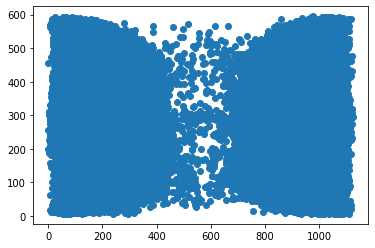

In [121]:
plt.scatter(xs,ys)

We only really care about the half court, so we reflect all points with x> half court about the origin. Note that to preserve the 'handedness' of a shot, we have to reflect about the origin, not half court: shooting from the bottom right is the same as shooting from the top left, not bottom left

In [122]:
#Court runs from apparently 0 to 1124 and ~0-600, so the origin is (300, 562), and we reflect a point if it's >562.
print(min(xs),max(xs), min(ys), max(ys))

0.0 1124.0 6.0 595.0


In [124]:
#This is just whats implemented above in halfcourt

for i in range(len(xs)):
    if xs[i] >562:
        xs[i] = 1124 - xs[i]

        ys[i] = 600-ys[i]
        

(0.0, 1124.0)

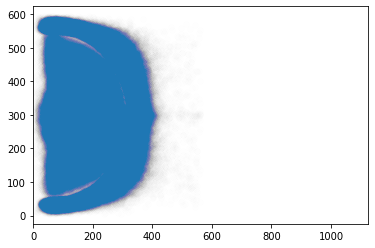

In [125]:
#Looks good
plt.scatter(xs,ys, alpha = 0.005)
plt.xlim(0,1124)

Now let's make some shotcharts. The actual code to make the chart is implemented above in shot_chart. You can check the documentation for it there. To see if it's working, let's take a look at my hometown team, the Rutgers Scarlet Knights. They play out of the Big10, and traditionally have been a very anti-money ball team, taking a lot of midrange jumpers, which they're ok at, and shooting poorly from 3. They get by on d and rebounding (not that we can see that) Let's see if that's born out

In [339]:
RU = df.loc[df['team_alias']=='RUTG']
b10 = df.loc[df['team_conf_alias'] =='BIG10']

scale = 24
percent_RU, selection_RU = shot_chart(RU, scale = scale)
percent_b10, selection_b10 = shot_chart(b10, scale = scale)
percent_ncaa, selection_ncaa = shot_chart(df, scale = scale)



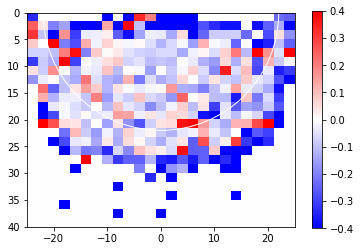

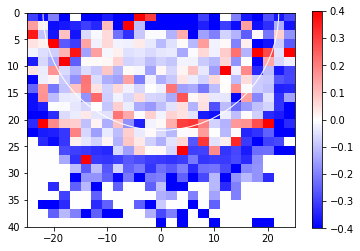

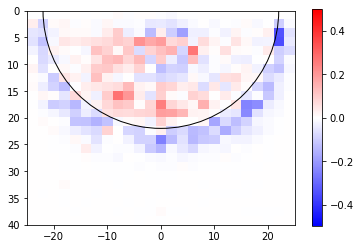

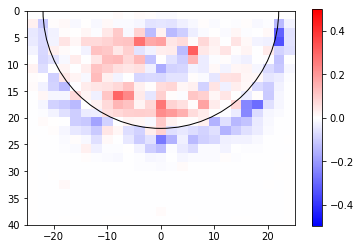

In [347]:
#RU Shooting normalized by B10 shooting (top) and full NCAA shooting (bottom)
fig, axes = plt.subplots()

plt.imshow((percent_RU-percent_b10)/(np.maximum(percent_b10,np.ones(percent_b10.shape))), extent = [-25,25,40,0], cmap = 'bwr', vmin = -0.4, vmax = 0.4)
plt.colorbar()
draw_circle = plt.Circle((0, 0), 22, color = 'white',fill=False, alpha = 1)
axes.set_aspect(1)
axes.add_artist(draw_circle)

plt.show()
plt.close()

fig, axes = plt.subplots()

plt.imshow((percent_RU-percent_ncaa)/(np.maximum(percent_ncaa,np.ones(percent_ncaa.shape))), extent = [-25,25,40,0], cmap = 'bwr', vmin = -0.4, vmax = 0.4)
plt.colorbar()
draw_circle = plt.Circle((0, 0), 22, color = 'white',fill=False, alpha = 1)
axes.set_aspect(1)
axes.add_artist(draw_circle)

plt.show()
plt.close()

fig, axes = plt.subplots()

plt.imshow((selection_RU-selection_b10)/(np.maximum(selection_b10,np.ones(selection_b10.shape)/100)), extent = [-25,25,40,0], cmap = 'bwr', vmin = -0.5, vmax = 0.5)
plt.colorbar()
draw_circle = plt.Circle((0, 0), 22, color = 'black',fill=False, alpha = 1)
axes.set_aspect(1)
axes.add_artist(draw_circle)

plt.show()
plt.close()

fig, axes = plt.subplots()

plt.imshow((selection_RU-selection_ncaa)/(np.maximum(selection_ncaa,np.ones(selection_ncaa.shape)/100)), extent = [-25,25,40,0], cmap = 'bwr', vmin = -0.5, vmax = 0.5)
plt.colorbar()
draw_circle = plt.Circle((0, 0), 22, color = 'black',fill=False, alpha = 1)
axes.set_aspect(1)
axes.add_artist(draw_circle)

plt.show()
plt.close()

It would appear our analysis is correct. Rutgers shoots a lot from midrange and they shoot it ok but they do not shoot a lot of 3s at all, and they don't shoot them particularly well. For comparison bellow, we show the Zags, a team that has historically shot well from 3

In [350]:
team = df.loc[df['team_alias']=='GONZ']
scale = 24

percent, selection = shot_chart(team, scale = scale)
percent_ncaa, selection_ncaa = shot_chart(df, scale = scale)


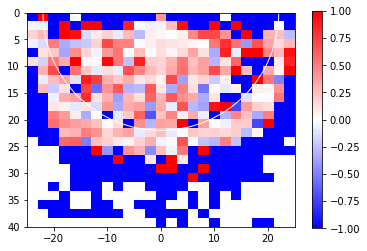

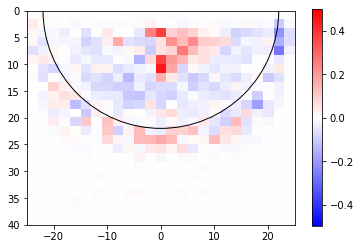

In [351]:
#For Compari

fig, axes = plt.subplots()

plt.imshow((percent-percent_ncaa)/(np.maximum(percent_ncaa,np.ones(percent_ncaa.shape)/100)), extent = [-25,25,40,0], cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
draw_circle = plt.Circle((0, 0), 22, color = 'white',fill=False, alpha = 1)
axes.set_aspect(1)
axes.add_artist(draw_circle)

plt.show()
plt.close()

fig, axes = plt.subplots()

plt.imshow((selection-selection_ncaa)/(np.maximum(selection_ncaa,np.ones(selection_ncaa.shape)/100)), extent = [-25,25,40,0], cmap = 'bwr', vmin = -0.5, vmax = 0.5)
plt.colorbar()
draw_circle = plt.Circle((0, 0), 22, color = 'black',fill=False, alpha = 1)
axes.set_aspect(1)
axes.add_artist(draw_circle)

plt.show()
plt.close()

array(['RUTG'], dtype=object)